# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [47]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

In [59]:
import pandas as pd

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

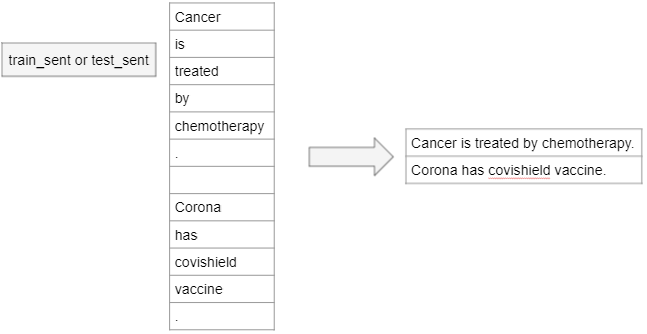

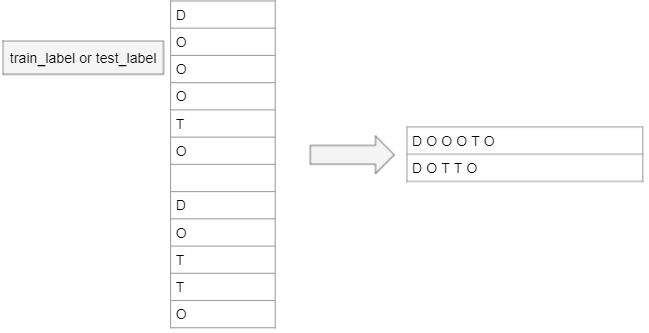

In [48]:
with open('train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()

In [49]:
train_sentences = [s.replace("\n", "") for s in train_sentences]
train_labels = [s.replace("\n", "") for s in train_labels]
test_sentences = [s.replace("\n", "") for s in test_sentences]
test_labels = [s.replace("\n", "") for s in test_labels]

In [50]:
def build_sentences(elements):
    sentences = []
    current_sentence = ""

    for element in elements:
        if element.strip():
            current_sentence += element + " "
        else:
            if current_sentence.strip():
                sentences.append(current_sentence.strip())
                current_sentence = ""

    if current_sentence.strip():
        sentences.append(current_sentence.strip())

    return sentences


# Call the method
train_sentences = build_sentences(train_sentences)
train_labels = build_sentences(train_labels)
test_sentences = build_sentences(test_sentences)
test_labels = build_sentences(test_labels)


In [51]:
# Print first five sentences from the processed dataset
for each_item in range(5):
    print("-"*100)
    print(f"Sentence {each_item+1} is: {train_sentences[each_item]}")
    print(f"Label {each_item+1} is: {train_labels[each_item]}")
    print("-"*100)

----------------------------------------------------------------------------------------------------
Sentence 1 is: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1 is: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Sentence 2 is: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label 2 is: O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------

### Count the number of sentences in the processed train and test dataset 

In [52]:
print(len(train_sentences))
print(len(test_sentences))

2599
1056


### Count the number of lines of labels in the processed train and test dataset.

In [53]:
print(len(train_labels))
print(len(test_labels))

2599
1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [56]:
word_counts={}

combined_sentence = train_sentences + test_sentences

# Process each sentence and print POS tags
for sentence in (train_sentences, test_sentences):
    doc = model(sentence)
    for token in doc:
        if token.pos_ in ['NOUN','PROPN']:
            word_counts[token.text] = word_counts.get(token.text, 0) + 1
            
for word, count in word_counts.items():
    print(f"{word} : {count}")

births : 3
weeks : 47
University : 6
Vermont : 1
delivery : 22
route : 2
indication : 7
age : 78
parity : 7
practice : 40
group : 125
risk : 93
status : 20
rate : 88
% : 333
presentation : 8
medicine : 43
patients : 630
Arrest : 1
dilation : 7
subgroups : 7
rates : 46
care : 65
hospitals : 12
community : 19
groups : 45
trimester : 4
fluid : 11
index : 15
AFI : 11
temperature : 15
increases : 10
decrease : 7
June : 2
August : 7
period : 34
heat : 8
women : 106
singleton : 1
pregnancies : 7
gestation : 4
testing : 35
determinations : 2
ambient : 1
area : 14
day : 45
mean : 5
test : 25
date : 4
Spearman : 1
rank : 3
Correlation : 3
relationship : 15
account : 4
measure : 5
well : 2
being : 2
study : 205
population : 39
diabetes : 39
screening : 14
clinic : 6
Hadassah : 1
Medical : 7
Center : 3
year : 65
treatment : 367
week : 16
protocol : 7
control : 72
characteristics : 22
differences : 31
mode : 3
Apgar : 1
scores : 12
infants : 31
cases : 96
aim : 9
contribution : 5
markers : 26
diagn

In [64]:

# Sort the dictionary by values in descending order
sorted_dict = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

print(sorted_dict)


{'patients': 630, 'treatment': 367, '%': 333, 'cancer': 265, 'therapy': 230, 'study': 205, 'cell': 181, 'disease': 179, 'lung': 145, 'group': 125, 'gene': 120, 'chemotherapy': 111, 'effects': 109, 'women': 106, 'results': 104, 'cases': 96, 'use': 95, 'TO_SEE': 94, 'risk': 93, 'analysis': 93, 'surgery': 91, 'response': 89, 'rate': 88, 'effect': 83, 'children': 81, 'survival': 80, 'age': 78, 'cells': 77, 'protein': 76, 'term': 75, 'patient': 74, 'dose': 74, 'control': 72, 'combination': 72, 'years': 71, 'data': 70, 'syndrome': 69, 'studies': 66, 'care': 65, 'year': 65, 'carcinoma': 65, 'case': 64, '#': 63, 'management': 62, 'evidence': 62, 'P': 60, 'trial': 59, 'activity': 59, 'stage': 58, 'health': 58, 'C': 58, 'mg': 57, 'diagnosis': 56, 'heart': 55, 'infection': 55, 'trials': 55, 'time': 54, 'growth': 53, 'bone': 53, 'B': 53, 'blood': 53, 'failure': 52, '-': 50, 'role': 50, 'method': 49, 'months': 49, 'tumor': 49, 'nsclc': 48, 'weeks': 47, 'pregnancy': 47, 'placebo': 47, 'rates': 46, '

In [65]:
# Create a new dictionary with the top 25 elements
top_25_dict = {k: sorted_dict[k] for k in list(sorted_dict.keys())[:25]}

# Print the new dictionary
print(top_25_dict)


{'patients': 630, 'treatment': 367, '%': 333, 'cancer': 265, 'therapy': 230, 'study': 205, 'cell': 181, 'disease': 179, 'lung': 145, 'group': 125, 'gene': 120, 'chemotherapy': 111, 'effects': 109, 'women': 106, 'results': 104, 'cases': 96, 'use': 95, 'TO_SEE': 94, 'risk': 93, 'analysis': 93, 'surgery': 91, 'response': 89, 'rate': 88, 'effect': 83, 'children': 81}


#### Another version using panda series 

In [58]:
# Creating a list to hold all the tokens which are either NOUN or PROPER NOUN
noun_propn_tokens_list = []

# Each token which is a NOUN or PROPN will be appended to the list "noun_propn_tokens_list"
for sentences in (train_sentences, test_sentences):
    for sent in sentences:
        processed_sent = model(sent)
        for each_token in processed_sent:
            if each_token.pos_ == "NOUN" or each_token.pos_ == "PROPN":
                noun_propn_tokens_list.append(each_token.text)

In [67]:
# Creating a Series to hold the tokens which are either NOUN or PROPER NOUN
df_noun_propn = pd.Series(noun_propn_tokens_list)

In [61]:
# Getting then count of each token and sorting the data in top 25 most token counts
df_noun_propn.value_counts().sort_values(ascending=False).head(25)

patients        630
treatment       367
%               333
cancer          265
therapy         230
study           205
cell            181
disease         179
lung            145
group           125
gene            120
chemotherapy    111
effects         109
women           106
results         104
cases            96
use              95
TO_SEE           94
risk             93
analysis         93
surgery          91
response         89
rate             88
effect           83
children         81
dtype: int64

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [63]:
# Get the top 25 most occurring values
top_25_values = df_noun_propn.value_counts().head(25)
top_25_values

patients        630
treatment       367
%               333
cancer          265
therapy         230
study           205
cell            181
disease         179
lung            145
group           125
gene            120
chemotherapy    111
effects         109
women           106
results         104
cases            96
use              95
TO_SEE           94
risk             93
analysis         93
surgery          91
response         89
rate             88
effect           83
children         81
dtype: int64

## Defining features for CRF





In [71]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [72]:
# Write a code to get features for a sentence.
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [73]:
# Write a code to get the labels for a sentence.
# Function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [75]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sentences[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[1]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=rates',
 'word[-3:]=tes',
 'word[-2:]=es',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=NOUN',
 'prev_word.lower=cesarean',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=True',
 'prev_word.pos=ADJ']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [76]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [77]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [78]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
# crf.fit(X_train, Y_train)

try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass
# predictions = crf.predict(X_test)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [79]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [80]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print(f"F1 score is: {round(f1_score,4)}")

F1 score is: 0.9087


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

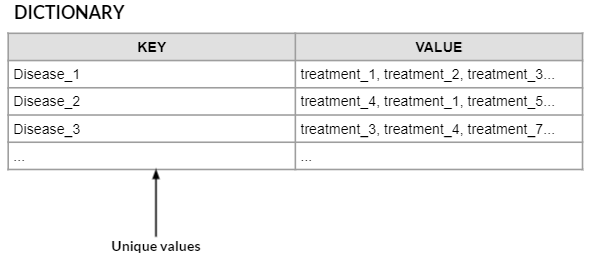

In [83]:
# Creating an empty dictionary to hold diseases and their corresponding treatments
D_T_dict = dict()

for i in range(len(Y_pred)):
    # Get the predicted labels of each test sentence into "val"
    val = Y_pred[i]
    
    # Empty strings to store the values of Diseases and Treatments
    Diseases = ""
    Treatments = ""
    
    # Each loop will iterate through the individual labels and focus on mapping D and T labels
    # with Diseases and Treatments within each sentence into a concatenated string
    for j in range(len(val)):
        if val[j] == 'D': # If label is D, it indicates a Disease 
            Diseases += test_sentences[i].split()[j] + " "
        elif val[j] == 'T': # If label is T, it indicates a Treatment
            Treatments += test_sentences[i].split()[j] + " "
            
    # Removes any extra whitespaces to either end of the string
    Diseases = Diseases.lstrip().rstrip()
    Treatments = Treatments.lstrip().rstrip()

    # If Diseases and Treatments are blank, ignore them
    # If Disease is not present in Dictionary, add it along with the corresponding treatment
    # If Disease is present in the Dictionary, append the treatments for that diseases with existing
    # treatments
    if Diseases != "" and Treatments != "":
        if Diseases in D_T_dict.keys():
            treat_out = list(D_T_dict[Diseases])
            treat_out.append(Treatments)
            D_T_dict[Diseases] = treat_out
        elif Diseases not in D_T_dict.keys():
            D_T_dict[Diseases] = Treatments

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [84]:
D_T_dict['hereditary retinoblastoma']

'radiotherapy'